In [ ]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [ ]:

import paper_dataloaders
import paper_models

from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from seqdata.dualrnn import *
from seqdata.hpopt import *
from fastai.basics import *
from fastai.callback.all import *
from seqdata.quaternions import *
from pathlib import Path
from ray import tune
import pickle

from paper_dataloaders import *
from paper_models import *

Library "haste_pytorch" not found


In [ ]:
import ray
from ray import tune
from fastai.basics import *
import pandas as pd
%matplotlib widget
#ray.shutdown()
ray.init() #auto is for attaching to a running local server

2024-04-25 11:22:31,947	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.9.3


In [ ]:
def load_df(experiment_path):
    experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
    experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
    df = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True)
    trials = list(flatten([exp.trials for exp in experiment_list]))
    df['trial'] = df.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))
    df['chkpt_path']= df['trial'].apply(lambda trial: experiment_list[0].get_last_checkpoint(trial=trial).path +'/model.pth')
    return df[df.training_iteration == 100]
    
df_4b = load_df(Path.home() / 'ray_results/FranSys_P4B_models')
df_4b = df_4b[(df_4b['config/pred_sz'] <= 500)]
df_4c = load_df(Path.home() / 'ray_results/FranSys_P4C_models')
df_4c = df_4c[df_4c['config/ablation']==0]
df_4d = load_df(Path.home() / 'ray_results/FranSys_P4D_models')

group_clms = ['config/dl','config/size','config/model','config/pred_sz','config/schedule_pred']
df = pd.concat([df_4b,df_4c,df_4d]).sort_values(group_clms)

2024-04-25 11:22:34,746	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 123 trial(s):
- learner_optimize_a08f9_00389: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00389: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00389_389_dl=Ship,pred_sz=300,size=small_2024-03-19_09-43-43')
- learner_optimize_a08f9_00390: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00390: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00390_390_dl=Quadrotor,pred_sz=500,size=small_2024-03-19_09-46-04')
- learner_optimize_a08f9_00391: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00391: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00391_391_dl=Robot,pred_sz=500,size=small_2024-03-19_10-14-24')
- learner_opti

In [ ]:
def r2_loss(y_pred,y_true):
    SS_res = torch.sum(torch.square(y_true - y_pred))
    SS_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + 1e-7)
    return r2

# Evaluate Models on Test Data

In [ ]:
def create_lrn(dls,config):

    pred_sz = config['pred_sz']
    if dls is None:
        if pred_sz is not None:
            dls = dict_dls_fransys_test[config['dl']](pred_sz= pred_sz,valid_stp_sz=pred_sz)
        else:
            dls = dict_dls_fransys_test[config['dl']]()
    n_u, n_y, n_x, init_sz, _ = get_dls_parameters(dict_dls_fransys_test[config['dl']])
    
    if config['model']== 'nargru':
        if config['size'] == 'small':
            model_type = model_narprog_small
        elif config['size'] == 'medium':
            model_type = model_narprog_medium
        elif config['size'] == 'large':
            model_type = model_narprog_large
    elif config['model']== 'argru_init':
        if config['size'] == 'small':
            model_type = model_ar_rnn_init_small
        elif config['size'] == 'medium':
            model_type = model_ar_rnn_init_medium
        elif config['size'] == 'large':
            model_type = model_ar_rnn_init_large
    elif config['model']== 'argru_washout':
        if config['size'] == 'small':
            model_type = model_ar_rnn_washout_small
        elif config['size'] == 'medium':
            model_type = model_ar_rnn_washout_medium
        elif config['size'] == 'large':
            model_type = model_ar_rnn_washout_large
    
    model = model_type(n_u,n_x,n_y,init_sz,
                       hidden_p=config['hidden_p'] if config['has_hidden_p'] else 0,
                       weight_p=config['weight_p'] if config['has_weight_p'] else 0)
        
    norm_mean,norm_std = extract_mean_std_from_dls(dls)
    norm_mean = norm_mean[...,-n_y:]
    norm_std = norm_std[...,-n_y:]
    if config['model'] == 'argru_init':
        model.rnn_prognosis.init_normalize_values(norm_mean,norm_std)
        
    elif config['model'] == 'argru_washout':
        model.rnn_model.init_normalize_values(norm_mean,norm_std)

    lrn = Learner(dls,model,loss_func=SkipNLoss(mae,init_sz),
                    metrics=[SkipNLoss(rmse,init_sz),
                            SkipNLoss(nrmse,init_sz),
                            SkipNLoss(r2_loss,init_sz)],
                  wd=config['wd'],
                 opt_func=partial(RAdam,beta=config['opt_beta']))
    
    lrn.add_cb(CancelNaNCallback())
    lrn.add_cb(TbpttResetCB())
    return lrn

configs_4a = pickle.load(open('configs_4A.p', 'rb'))
@ray.remote(num_gpus=1/5)
def test_error_ray(row):
    config = {'dl':row['config/dl'],
              'model':row['config/model'],
              'size':row['config/size'],
                'pred_sz':row['config/pred_sz']}
    config_id = tuple([row['config/dl'],row['config/model'],row['config/size']])
    config.update(configs_4a[config_id])
    lrn = create_lrn(None,config)
    lrn.load_state_dict(torch.load(row['chkpt_path']))
    
    with (lrn.no_bar(),lrn.no_logging()):
        return lrn.validate()[-3:]

metrics = ray.get(list(df.apply(test_error_ray.remote,axis=1)))

#test_rmse = list(df.apply(test_error_ray,axis=1))

(pid=3875143) Library "haste_pytorch" not found
(pid=3885565) Library "haste_pytorch" not found [repeated 20x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(pid=3895778) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3904626) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3914240) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3920255) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3931215) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3940922) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3950185) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=3958184) Library "haste_pytorch" not found [repeated 18x across cluster]
(pid=3961417) Library "haste_pytorch" not found [repeat

In [ ]:
df['rmse'] = [x[-3] for x in metrics]
df['nrmse'] = [x[-2] for x in metrics]
df['r2'] = [x[-1] for x in metrics]

In [ ]:
df.loc[(df['config/model'] == 'argru_washout'),'model'] = 'AR-RNN'
df.loc[(df['config/model'] == 'argru_init'),'model'] = 'AR-RNN-Init'
df.loc[(df['config/model'] == 'nargru') & pd.isna(df['config/with_state_sync']),'model'] = 'NAR-RNN'
df.loc[(df['config/model'] == 'nargru') & ~pd.isna(df['config/with_state_sync']),'model'] = 'FranSys'

In [ ]:
#evaluate ship-ood dataset
df_ship_ood = (df[(df['config/dl'] == 'Ship')]).copy()
@ray.remote(num_gpus=1/5)
def test_ship_ood_ray(row):
    config = {'dl':row['config/dl'],
              'model':row['config/model'],
              'size':row['config/size'],
                'pred_sz':row['config/pred_sz']}
    config_id = tuple([row['config/dl'],row['config/model'],row['config/size']])
    config.update(configs_4a[config_id])
    dls = create_dls_ship_prediction_test_ood(pred_sz= row['config/pred_sz'])
    lrn = create_lrn(dls,config)
    lrn.load_state_dict(torch.load(row['chkpt_path']))
    
    with (lrn.no_bar(),lrn.no_logging()):
        return lrn.validate()[-3:]
metrics = ray.get(list(df_ship_ood.apply(test_ship_ood_ray.remote,axis=1)))   
df_ship_ood['rmse'] = [x[-3] for x in metrics]
df_ship_ood['nrmse'] = [x[-2] for x in metrics]
df_ship_ood['r2'] = [x[-1] for x in metrics]
df = pd.concat([df ,df_ship_ood.replace('Ship','Ship-OOD')])

(pid=1038633) Library "haste_pytorch" not found
(pid=1048007) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1057631) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1063685) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1073949) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1080829) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1090457) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1100574) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1109421) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1118756) Library "haste_pytorch" not found [repeated 20x across cluster]
(pid=1127180) Library "haste_pytorch" not found [repeated 14x across cluster]
(pid=1133292) Library "haste_pytorch" not found [repeated 12x across cluster]
(pid=1141219) Library "haste_pytorch" not found [repeated 19x across cluster]
(pid=1150896) Li

In [ ]:
df

,train_loss,valid_loss,_rmse,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,...,config/with_diag_loss,config/sync_type,config/p_state_sync,config/p_diag_loss,config/with_tar_loss,config/p_tar_loss,rmse,nrmse,r2,model
81,0.058654,0.138773,0.232196,1711340651,checkpoint_000099,True,False,100,869aa_00060,2024-03-25_05-24-11,...,NaN,NaN,NaN,NaN,NaN,NaN,0.136333,0.353207,0.916628,AR-RNN-Init
122,0.059773,0.138970,0.232135,1711306453,checkpoint_000099,True,False,100,82187_00150,2024-03-24_18-54-13,...,NaN,NaN,NaN,NaN,NaN,NaN,0.137765,0.358788,0.914965,AR-RNN-Init
197,0.059474,0.139636,0.233443,1711287526,checkpoint_000099,True,False,100,82187_00060,2024-03-24_13-38-46,...,NaN,NaN,NaN,NaN,NaN,NaN,0.137058,0.356612,0.915818,AR-RNN-Init
343,0.059592,0.138557,0.231909,1711327940,checkpoint_000099,True,False,100,82187_00240,2024-03-25_00-52-20,...,NaN,NaN,NaN,NaN,NaN,NaN,0.137079,0.356180,0.915837,AR-RNN-Init
421,0.058988,0.138941,0.231906,1711351613,checkpoint_000099,True,False,100,82187_00330,2024-03-25_07-26-53,...,NaN,NaN,NaN,NaN,NaN,NaN,0.135987,0.355240,0.917164,AR-RNN-Init
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0.042998,0.038267,0.087317,1711041788,checkpoint_000099,True,False,100,44942_00479,2024-03-21_17-23-08,...,True,cos_pow,6.153847,0.031615,NaN,NaN,0.208530,0.422807,0.995306,FranSys
658,0.042494,0.037154,0.082253,1711048367,checkpoint_000099,True,False,100,44942_00569,2024-03-21_19-12-47,...,True,cos_pow,6.153847,0.031615,NaN,NaN,0.222028,0.441368,0.994676,FranSys
748,0.043012,0.038971,0.087090,1711055582,checkpoint_000099,True,False,100,44942_00659,2024-03-21_21-13-02,...,True,cos_pow,6.153847,0.031615,NaN,NaN,0.222995,0.442277,0.994596,FranSys
838,0.042512,0.039517,0.089977,1711062344,checkpoint_000099,True,False,100,44942_00749,2024-03-21_23-05-44,...,True,cos_pow,6.153847,0.031615,NaN,NaN,0.200579,0.403974,0.995617,FranSys


In [ ]:
df.to_pickle('df_4d.p')

# Barplot

In [ ]:
df = pd.read_pickle('df_4d.p')

In [ ]:
custom_palette = {
    # 'FranSys': 'cornflowerblue',  # Blue
    'FranSys': 'firebrick',  # Blue
    'NAR-RNN': 'darkcyan',  # Orange
    'AR-RNN': 'dimgray',  # Orange
    'AR-RNN-Init': 'darkgray'   # Lighter Orange
}
plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    'font.family': "Times New Roman"
})

df_filt = pd.concat([
    df[(df['model'] == 'AR-RNN')],
    df[(df['model'] == 'AR-RNN-Init')],
    df[(df['model'] == 'NAR-RNN')& ~(df['config/schedule_pred'])],
    df[(df['model'] == 'FranSys')& (df['config/schedule_pred'])]
])

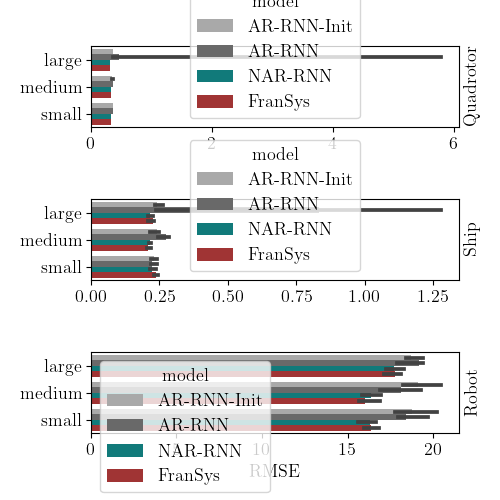

In [ ]:
import seaborn as sns
fig, (axs) = plt.subplots(ncols=1,nrows=3, figsize=(5, 5), sharey=True, gridspec_kw={'wspace': 0})

df_bar = df[df['config/pred_sz'] == 500]


#No optimized hyperparameters
ax = axs[0]
sns.barplot(ax=ax,data=df_bar[df_bar['config/dl']=='Quadrotor'],y='config/size',hue='model',x='rmse',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
ax.set_xlabel("")
ax.set_ylabel('Quadrotor')
ax.yaxis.set_label_position("right")

ax = axs[1]
sns.barplot(ax=ax,data=df_bar[df_bar['config/dl']=='Ship-OOD'],y='config/size',hue='model',x='rmse',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
ax.set_xlabel("")
ax.set_ylabel('Ship')
ax.yaxis.set_label_position("right")

ax = axs[2]
sns.barplot(ax=ax,data=df_bar[df_bar['config/dl']=='Robot'],y='config/size',hue='model',x='rmse',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
# ax.set_ylabel("")
ax.set_ylabel('Robot')
ax.yaxis.set_label_position("right")
ax.set_xlabel("RMSE")


plt.tight_layout()
plt.savefig('P4D_barplot.pdf')

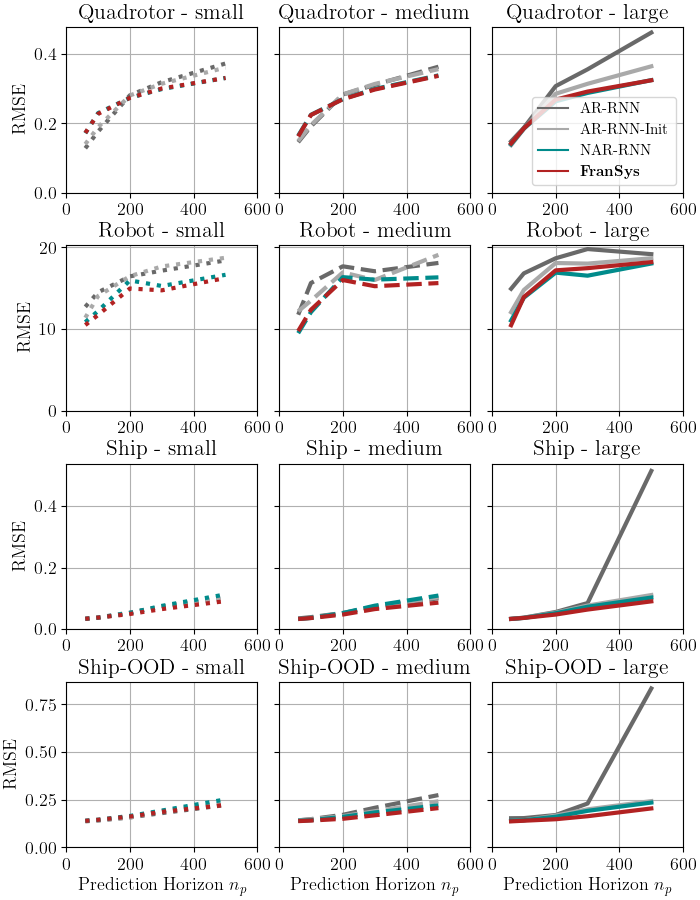

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(7, 9))
linestyles = {'small': ':', 'medium': '--', 'large': '-'}
sizes = ['small', 'medium', 'large']
datasets = df['config/dl'].unique()

model_order = ['AR-RNN','AR-RNN-Init','NAR-RNN', 'FranSys']


for j, size in enumerate(sizes):
    for i, dataset in enumerate(datasets):
        # Filtering data for the current dataset and size
        df_subset = df_filt[(df_filt['config/dl'] == dataset) & (df_filt['config/size'] == size)]
        ax = axes[i, j]
        
        # Since seaborn's lineplot may not directly accept a 'dashes' parameter with a dictionary as we initially attempted,
        # we will apply the linestyles after plotting by accessing the lines drawn by seaborn and setting their linestyles.
        sns.lineplot(data=df_subset, x='config/pred_sz', y='rmse', hue='model',estimator='median',errorbar=None, ax=ax,palette=custom_palette,hue_order=model_order, lw=3)
        
        # Setting line styles post-hoc
        lines = ax.get_lines()  # Get the lines that seaborn has plotted
        for line in lines:
            line.set_linestyle(linestyles[size])  # Set linestyle based on the model size
        
        ax.set_ylim(0)
        ax.legend().set_visible(False)  # Hide legend to avoid repetition
        ax.set_title(f"{dataset} - {size}")
        ax.set_xticks([0,200,400,600])
        ax.grid()
        if j > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('RMSE')
        if i < 3:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Prediction Horizon $n_p$')
            
for idx_row in range(axes.shape[0]):
    y_max = max([ax.get_ylim()[-1] for ax in axes[idx_row,:]])
    for ax in axes[idx_row,:]:
        ax.set_ylim(0,y_max)
        
ax = axes[0, 2]
handles, labels = ax.get_legend_handles_labels()
labels[-1] = r'\textbf{' + labels[-1] + '}'
ax.legend(handles=handles, labels=labels,title=None, loc='lower right',fontsize='small')
plt.tight_layout(pad=0.2)

plt.savefig('P4D_individual.pdf')

# Scatter Plot

/tmp/ipykernel_1663685/3331717737.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/3331717737.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/3331717737.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/3331717737.py:47: UserWarning: Ignoring `palett

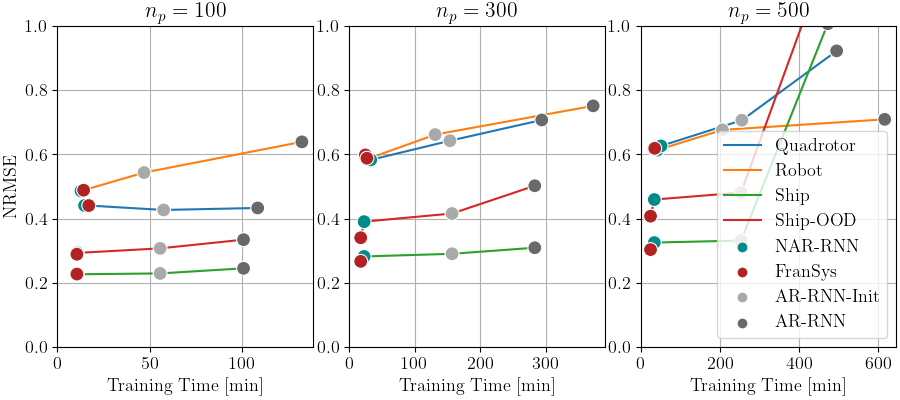

In [ ]:
import seaborn as sns
hyperparameters = ['config/dl','config/size','model','config/pred_sz']

fig, axes = plt.subplots(1, 3, figsize=(9, 4))

size = 'large'
for i,pred_sz in enumerate([100,300,500]):
    ax=axes[i]
    
    df_prefilt = df_filt[(df_filt['config/pred_sz'] == pred_sz) & (df_filt['config/size'] == size)].reset_index()
    group_median = df_prefilt.groupby(hyperparameters)['nrmse'].transform('median')
    df_prefilt['median_diff'] = (df_prefilt['nrmse'] - group_median).abs()
    df_median = df_prefilt.loc[df_prefilt.groupby(hyperparameters)['median_diff'].idxmin()]
    
    min_time_iter_s = df_prefilt.groupby(hyperparameters)['time_total_s'].min().reset_index()
    df_median = pd.merge(df_median, min_time_iter_s, on=hyperparameters, suffixes=('', '_min'))
    df_median['time_total_s'] = df_median['time_total_s_min']/60
    df_filtered = df_median.drop(columns=['time_total_s_min', 'median_diff']).reset_index(drop=True)
    
    
    legend_labels = set()  # To track which line labels have been added to the legend
    
    # Define marker sizes based on model sizes. Adjust these values as needed.
    model_sizes = {'small': 50, 'medium': 100, 'large': 100}
    # If the model sizes are numeric or differently named, adjust the keys accordingly.
    
    # Iterate over each unique value in 'config/dl' to draw lines
    for dl_value in df_filtered['config/dl'].unique():
        df_subset = df_filtered[df_filtered['config/dl'] == dl_value]
        for size_value in df_filtered['config/size'].unique():
            df_subsubset = df_subset[df_subset['config/size'] == size_value]
            
            # Sort the dataframe if necessary
            df_subsubset = df_subsubset.sort_values(by='time_total_s')
            
            # Plot lines connecting the points
            label = f'{dl_value}' if f'{dl_value}' not in legend_labels else None
            ax.plot(df_subsubset['time_total_s'], df_subsubset['nrmse'], marker='', linestyle=linestyles[size], label=label)
            if label:  # Mark this dataset as plotted
                legend_labels.add(f'{dl_value}')
    
    # Plotting the scatter plot with varying marker sizes
    for model_size, s in model_sizes.items():
        # Filter the dataframe for each model size
        df_model_size = df_filtered[df_filtered['config/size'] == model_size]
        #sns.scatterplot(data=df_model_size, x='time_total_s', y='nrmse', hue='model',s=s,legend='auto' if model_size == 'large' else False,palette=custom_palette)  # Use a generic color or another criteria for distinction
        sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction

    ax.set_xlim(0)
    ax.set_ylim(0,1)
    ax.set_title(f'$n_p={pred_sz}$')
    ax.grid()
    ax.set_xlabel('Training Time [min]')
    ax.legend().set_visible(False)  # Hide legend to avoid repetition
    if i==0:
        ax.set_ylabel('NRMSE')
    else:
        ax.set_ylabel(None)
        #ax.set_yticks(ax.get_yticks(),labels=[])
        
plt.tight_layout(pad=0.2) 

# Adjust the legend
axes[-1].legend(title=None,  loc='lower right')
plt.savefig('P4D_scatter.pdf')
plt.show()

/tmp/ipykernel_1663685/2723812195.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/2723812195.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/2723812195.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction
/tmp/ipykernel_1663685/2723812195.py:47: UserWarning: Ignoring `palett

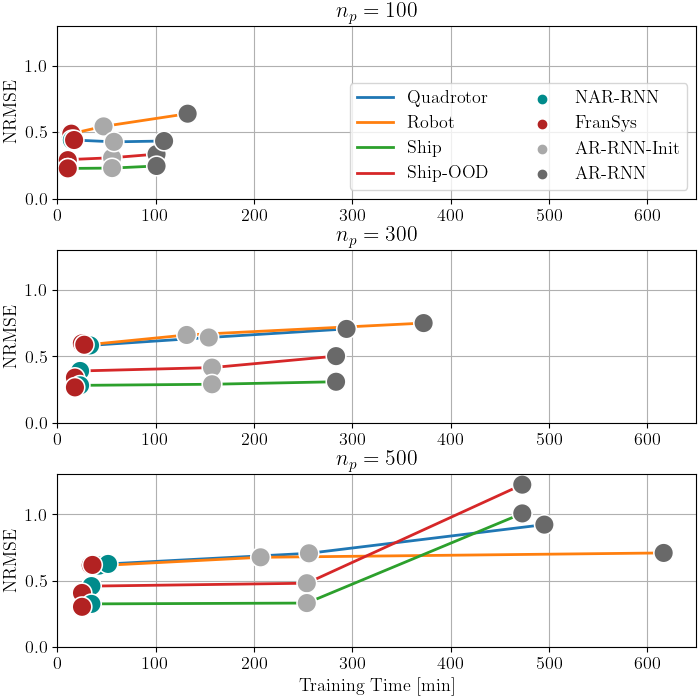

In [ ]:
import seaborn as sns
hyperparameters = ['config/dl','config/size','model','config/pred_sz']

fig, axes = plt.subplots(3, 1, figsize=(7, 7))

size = 'large'
for i,pred_sz in enumerate([100,300,500]):
    ax=axes[i]
    
    df_prefilt = df_filt[(df_filt['config/pred_sz'] == pred_sz) & (df_filt['config/size'] == size)].reset_index()
    group_median = df_prefilt.groupby(hyperparameters)['nrmse'].transform('median')
    df_prefilt['median_diff'] = (df_prefilt['nrmse'] - group_median).abs()
    df_median = df_prefilt.loc[df_prefilt.groupby(hyperparameters)['median_diff'].idxmin()]
    
    min_time_iter_s = df_prefilt.groupby(hyperparameters)['time_total_s'].min().reset_index()
    df_median = pd.merge(df_median, min_time_iter_s, on=hyperparameters, suffixes=('', '_min'))
    df_median['time_total_s'] = df_median['time_total_s_min']/60
    df_filtered = df_median.drop(columns=['time_total_s_min', 'median_diff']).reset_index(drop=True)
    
    
    legend_labels = set()  # To track which line labels have been added to the legend
    
    # Define marker sizes based on model sizes. Adjust these values as needed.
    model_sizes = {'small': 50, 'medium': 100, 'large': 200}
    # If the model sizes are numeric or differently named, adjust the keys accordingly.
    
    # Iterate over each unique value in 'config/dl' to draw lines
    for dl_value in df_filtered['config/dl'].unique():
        df_subset = df_filtered[df_filtered['config/dl'] == dl_value]
        for size_value in df_filtered['config/size'].unique():
            df_subsubset = df_subset[df_subset['config/size'] == size_value]
            
            # Sort the dataframe if necessary
            df_subsubset = df_subsubset.sort_values(by='time_total_s')
            
            # Plot lines connecting the points
            label = f'{dl_value}' if f'{dl_value}' not in legend_labels else None
            ax.plot(df_subsubset['time_total_s'], df_subsubset['nrmse'], marker='', linestyle=linestyles[size], label=label,lw=2)
            if label:  # Mark this dataset as plotted
                legend_labels.add(f'{dl_value}')
    
    # Plotting the scatter plot with varying marker sizes
    for model_size, s in model_sizes.items():
        # Filter the dataframe for each model size
        df_model_size = df_filtered[df_filtered['config/size'] == model_size]
        #sns.scatterplot(data=df_model_size, x='time_total_s', y='nrmse', hue='model',s=s,legend='auto' if model_size == 'large' else False,palette=custom_palette)  # Use a generic color or another criteria for distinction
        sns.scatterplot(data=df_model_size.iloc[::-1], x='time_total_s', y='nrmse', hue='model',s=s,palette=custom_palette,zorder=2,ax=ax)  # Use a generic color or another criteria for distinction

    ax.set_xlim(0,650)
    ax.set_ylim(0,1.3)
    ax.set_title(f'$n_p={pred_sz}$')
    ax.grid()
    ax.set_ylabel('NRMSE')
    ax.legend().set_visible(False)  # Hide legend to avoid repetition
    if i==2:
        ax.set_xlabel('Training Time [min]')
    else:
        ax.set_xlabel(None)
        #ax.set_yticks(ax.get_yticks(),labels=[])
        
plt.tight_layout(pad=0.2) 

# Adjust the legend
axes[0].legend(title=None,  loc='lower right',ncols=2)
plt.savefig('P4D_scatter.pdf')
plt.show()

# Relinet Comparison

## Retrieve Relinet Data

In [ ]:
f_path = Path.home() / 'local_data/relinet_results/industrial-robot/repeat-1/LSTM+Init-256-4/test-w_60-h_60.hdf5'

def retrieve_test_sequences(f_path):
    pred = []
    true = []
    with h5py.File(f_path, 'r') as f:
            file_names = [
                fn.decode('UTF-8') for fn in f['main']['metadata']['file_names'][:].tolist()
            ]
            for i in range(len(file_names)):
                pred.append(
                    f['main'][str(i)]['outputs']['pred_state'][:].astype(np.float64)
                )
                true.append(
                    f['main'][str(i)]['outputs']['true_state'][:].astype(np.float64)
                )
    test_pred = np.array(pred)
    test_true = np.array(true)
    return test_pred,test_true
test_pred,test_true = retrieve_test_sequences(f_path)

def test_metric(f_path,metric):
    test_pred,test_true = retrieve_test_sequences(f_path)
    return float(metric(tensor(test_pred),tensor(test_true)))
test_metric(f_path,rmse)

14.613957405090332

In [ ]:
relinet_path = Path.home() / 'local_data/relinet_results/'
f_list = get_hdf_files(relinet_path).filter(lambda f:f.name == 'test-w_60-h_60.hdf5')
df_relinet = pd.DataFrame({
    'model':f_list.map(lambda x: x.parent.name),
    'rmse':f_list.map(lambda x: test_metric(x,rmse)),
    'nrmse':f_list.map(lambda x: test_metric(x,nrmse)),
    'config/dl':f_list.map(lambda p: first(p.parents,lambda x:x.parent.name == 'relinet_results').name),
    'f_path':f_list
}).replace('ship-ood','Ship-OOD').replace('ship-ind','Ship').replace('industrial-robot','Robot')

# Reapply renaming, this time ensuring AR-RNN-Init remains distinct
df_relinet['model'] = df_relinet['model'].replace({
    r'^(LSTM).*$': 'LSTM',  # Rename any LSTM variants to LSTM
    r'^(QLag).*$': 'QLag',  # Rename any QLag variants to QLag
    r'^(ReLiNet).*$': 'ReLiNet',  # Rename any ReLiNet variants to ReLiNet
    r'^(StableReLiNet).*$': 'StableReLiNet'  # Rename any StableReLiNet variants to StableReLiNet
}, regex=True)

In [ ]:
df_relinet

,model,rmse,nrmse,config/dl,f_path
0,StableReLiNet,0.070018,0.274960,Ship,/home/pheenix/local_data/relinet_results/ship-ind/StableReLiNet-64-3/test-w_60-h_60.hdf5
1,StableReLiNet,0.068211,0.292944,Ship,/home/pheenix/local_data/relinet_results/ship-ind/repeat-1/StableReLiNet-64-3/test-w_60-h_60.hdf5
2,LSTM,0.058398,0.272275,Ship,/home/pheenix/local_data/relinet_results/ship-ind/repeat-1/LSTM+Init-128-3/test-w_60-h_60.hdf5
3,QLag,0.119849,0.356231,Ship,/home/pheenix/local_data/relinet_results/ship-ind/repeat-1/QLag-60/test-w_60-h_60.hdf5
4,ReLiNet,0.072866,0.290617,Ship,/home/pheenix/local_data/relinet_results/ship-ind/repeat-1/ReLiNet-256-2/test-w_60-h_60.hdf5
...,...,...,...,...,...
115,QLag,10.244425,0.451420,Robot,/home/pheenix/local_data/relinet_results/industrial-robot/repeat-7/QLag-15/test-w_60-h_60.hdf5
116,StableReLiNet,17.933416,0.736691,Robot,/home/pheenix/local_data/relinet_results/industrial-robot/repeat-3/StableReLiNet-128-3/test-w_60-h_60.hdf5
117,ReLiNet,16.925232,0.705297,Robot,/home/pheenix/local_data/relinet_results/industrial-robot/repeat-3/ReLiNet-256-4/test-w_60-h_60.hdf5
118,LSTM,14.316112,0.569132,Robot,/home/pheenix/local_data/relinet_results/industrial-robot/repeat-3/LSTM+Init-256-4/test-w_60-h_60.hdf5


# Evaluate trained models

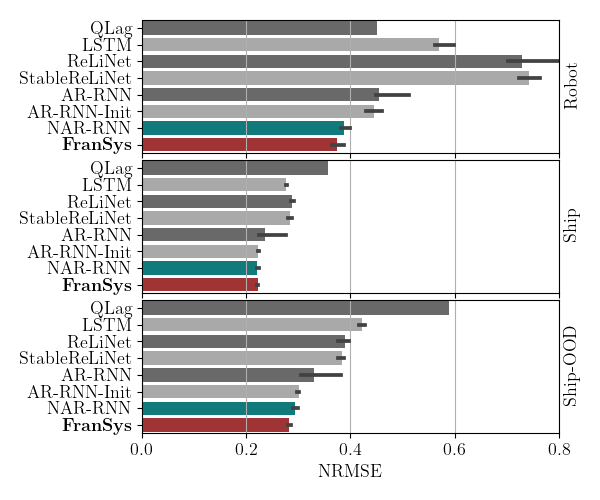

In [ ]:
import seaborn as sns
fig, (axs) = plt.subplots(ncols=1,nrows=3, figsize=(6, 5), sharey=True, gridspec_kw={'wspace': 0})
model_order = [ 'QLag', 'LSTM',  'ReLiNet',
       'StableReLiNet','AR-RNN','AR-RNN-Init','NAR-RNN', 'FranSys']
grey_tones = ['dimgrey', 'darkgrey']  # Alternating tones
palette = {model: 'firebrick' if model == 'FranSys' else 'darkcyan' if model == 'NAR-RNN' else grey_tones[i % 2] for i, model in enumerate(model_order)}
df_relibar = pd.concat([
    df_filt[(df_filt['config/pred_sz'] == 60)& ((df_filt['config/dl']=='Robot')|
                                                (df_filt['config/dl']=='Ship')|
                                                (df_filt['config/dl']=='Ship-OOD'))],
df_relinet])

for idx, ds in enumerate(df_relibar['config/dl'].unique()):

    ax = axs[idx]
    sns.barplot(ax=ax,data=df_relibar[df_relibar['config/dl']==ds],y='model',x='nrmse',estimator='median',order=model_order,palette=palette)
    ax.set_xlim(0,0.8)
    ax.set_xlabel("")
    ax.set_ylabel(ds)
    ax.grid(axis='x')
    ax.yaxis.set_label_position("right")
    if idx == 2: 
        ax.set_xlabel("NRMSE")
    else:
        ax.set_xticklabels([])

    labels = [label.get_text() for label in ax.get_yticklabels()]
    labels[-1] = r'\textbf{' + labels[-1] + '}'
    ax.set_yticklabels(labels)

plt.tight_layout(h_pad=0.1)
plt.savefig('P4D_relinet.pdf')